# Create load parity-check and generator matrices

In [1]:
import os.path, sys, bz2
import numpy as np
import pyldpc as ldpc

In [2]:
def getBinaryMatrix(source):
    """Creates a binary matrix of type :class:`np.ndarray` from either a file or a
    two-dimensional python list.
    If `source` is a file path, the file must eitheddr contain an explicit representation of the
    matrix (by means of whitespace-separated '0' and '1' characters) or be in the AList format
    (see alistToNumpy docstring).
    The file may be bzip2'ed, in which case it will be decompressed automatically.
    Returns
    -------
    np.ndarray[dtype=int]
        Numpy ndarray representation of the given matrix.
    """

    source = os.path.expanduser(source)
    fileObj = bz2.BZ2File(source, 'r') if source.endswith('bz2') else open(source, 'rt')
    with fileObj as f:
        lines = [[int(x) for x in l.strip().split()]
                  for l in f.readlines()
                  if len(l.strip()) > 0]

    if lines[0][0] in (0, 1):  # explicit 0/1 representation
        return np.array(lines, dtype=np.int)
    return alistToNumpy(lines)

def alistToNumpy(lines):
    """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
    list-of-lists corresponding to the lines of the AList format, already parsed to integers
    if read from a text file.
    The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
    This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
    weights, respectively) and the row-based information (last part of the Alist file) are omitted.
    Example:
        >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
        array([[1, 0, 1],
               [0, 1, 1]])
    """
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=int)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix

In [3]:
H = getBinaryMatrix('LDPC/CCSDS_ldpc_n32_k16.alist')
G = ldpc.coding_matrix(H, sparse=False).T

In [4]:
# Check whether GenMatrix is correctly calculated
G @ H.T % 2

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
k = 16
N = 32

In [6]:
def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

In [7]:
inputs = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    inputs[i]= inc_bool(inputs[i-1])
codewords = inputs @ G % 2

In [8]:
inputs.shape, codewords.shape

((65536, 16), (65536, 32))

# Define NN

In [9]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input, TimeDistributed
from keras import backend as K
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from scipy.spatial import distance
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[]

In [20]:
nb_epoch = 2**17
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
noise = True
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

In [11]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

def reshape_codebook(cb):
    global N
    global output_shape_test
    output_shape_test = tf.reshape(cb, (-1, N, 1))
    return output_shape_test

output_shape_test = (0, 0, 0)

In [12]:
def update_model(current_arch):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    # Reshape layer
    reshape_layer = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape')]
    reshape = compose_model(reshape_layer)
    reshape.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    
    # Define decoder
    
    if current_arch == 'dense-128-64-32':
        decoder_layers = [Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'dense-256-128-64-32':
        decoder_layers = [Dense(256, activation='relu', input_shape=(N,)),
                          Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-64':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-128':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu', return_sequences=True), 
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu', return_sequences=True),
                          LSTM(128, activation='relu', return_sequences=True),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])


    # Define model
#     if (LLR and noise):
#         model_layers = modulator_layers + noise_layers  + llr_layers + decoder_layers
#     elif (not LLR and noise):
#         model_layers = modulator_layers + noise_layers + decoder_layers
#     elif (not LLR and not noise):
#         model_layers = modulator_layers + decoder_layers

    if noise:
        model_layers = modulator_layers + noise_layers + decoder_layers
    else:
        model_layers = modulator_layers + decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

# Split codebook into train and validation sets (train:49152, val:16384)

In [35]:
code = 'LDPC CCSDS 16/32'
train_size = int(codewords.shape[0] * 0.75)
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
# print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
inputs_test = np.delete(inputs, idx, axis=0)
codewords_test = np.delete(codewords, idx, axis=0)

In [26]:
inputs_train.shape, codewords_train.shape, inputs_test.shape, codewords_test.shape

((49152, 16), (49152, 32), (16384, 16), (16384, 32))

### Fit model

In [21]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 18h 10min 6s, sys: 2h 46min 18s, total: 20h 56min 24s
Wall time: 13h 38min 32s


In [ ]:
model.save('LDPC/model-ldpc')
model.save('LDPC/decoder-ldpc')

In [ ]:
decoder = load_model('LDPC/decoder-ldpc', custom_objects={'errors':errors})

In [24]:
test_batch = 100000

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 10
SNR_points = 10

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((1,2**k,len(sigmas)),dtype=int)
nb_bits = np.zeros((1,2**k,len(sigmas)),dtype=int)
exp_descr = []

In [28]:
exp_descr.append('LDPC train on 49152, test on 16384 random')                                          # Add legend

for i in range(0,len(sigmas)):
    for ii in range(0,codewords_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{codewords_test.shape[0]}   ', end="\r")
        
        inputs_test_batch = np.tile(inputs_test[ii], (test_batch, 1))
        codewords_test_batch = np.tile(codewords_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*codewords_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += inputs_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, inputs_test_batch, batch_size=test_batch, verbose=0)[1]

In [31]:
# number of errors in .npy format
np.save(f'LDPC/random-picking/{nb_epoch}-train_{test_batch}-test_errors', nb_errors)

In [32]:
# number of errors in .npy format
np.save(f'LDPC/random-picking/{nb_epoch}-train_{test_batch}-test_bits', nb_bits)

In [33]:
# experimet descriptions (legend)
with open(f'LDPC/random-picking/{nb_epoch}-train_{test_batch}-test_exp_descr.txt', 'w') as filehandle:
    for listitem in exp_descr:
        filehandle.write('%s\n' % listitem)

In [36]:
# number of errors in .npy format
bits = np.load(f'LDPC/random-picking/{nb_epoch}-train_{test_batch}-test_bits.npy')

In [37]:
errors = np.load(f'LDPC/random-picking/{nb_epoch}-train_{test_batch}-test_errors.npy')

In [38]:
exp_descr = []

# open file and read the content in a list
with open('LDPC/random-picking/131072-train_100000-test_exp_descr.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        exp = line[:-1]

        # add item to the list
        exp_descr.append(exp)

In [39]:
# [experiment, bits, sigmas]
# [1,2**k,len(sigmas)]
bits.shape, errors.shape, len(exp_descr)

((1, 65536, 10), (1, 65536, 10), 1)

# Plot results

<ipython-input-40-a7d393767f09>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(errors[experiment,:,-1]/bits[experiment,:,-1])


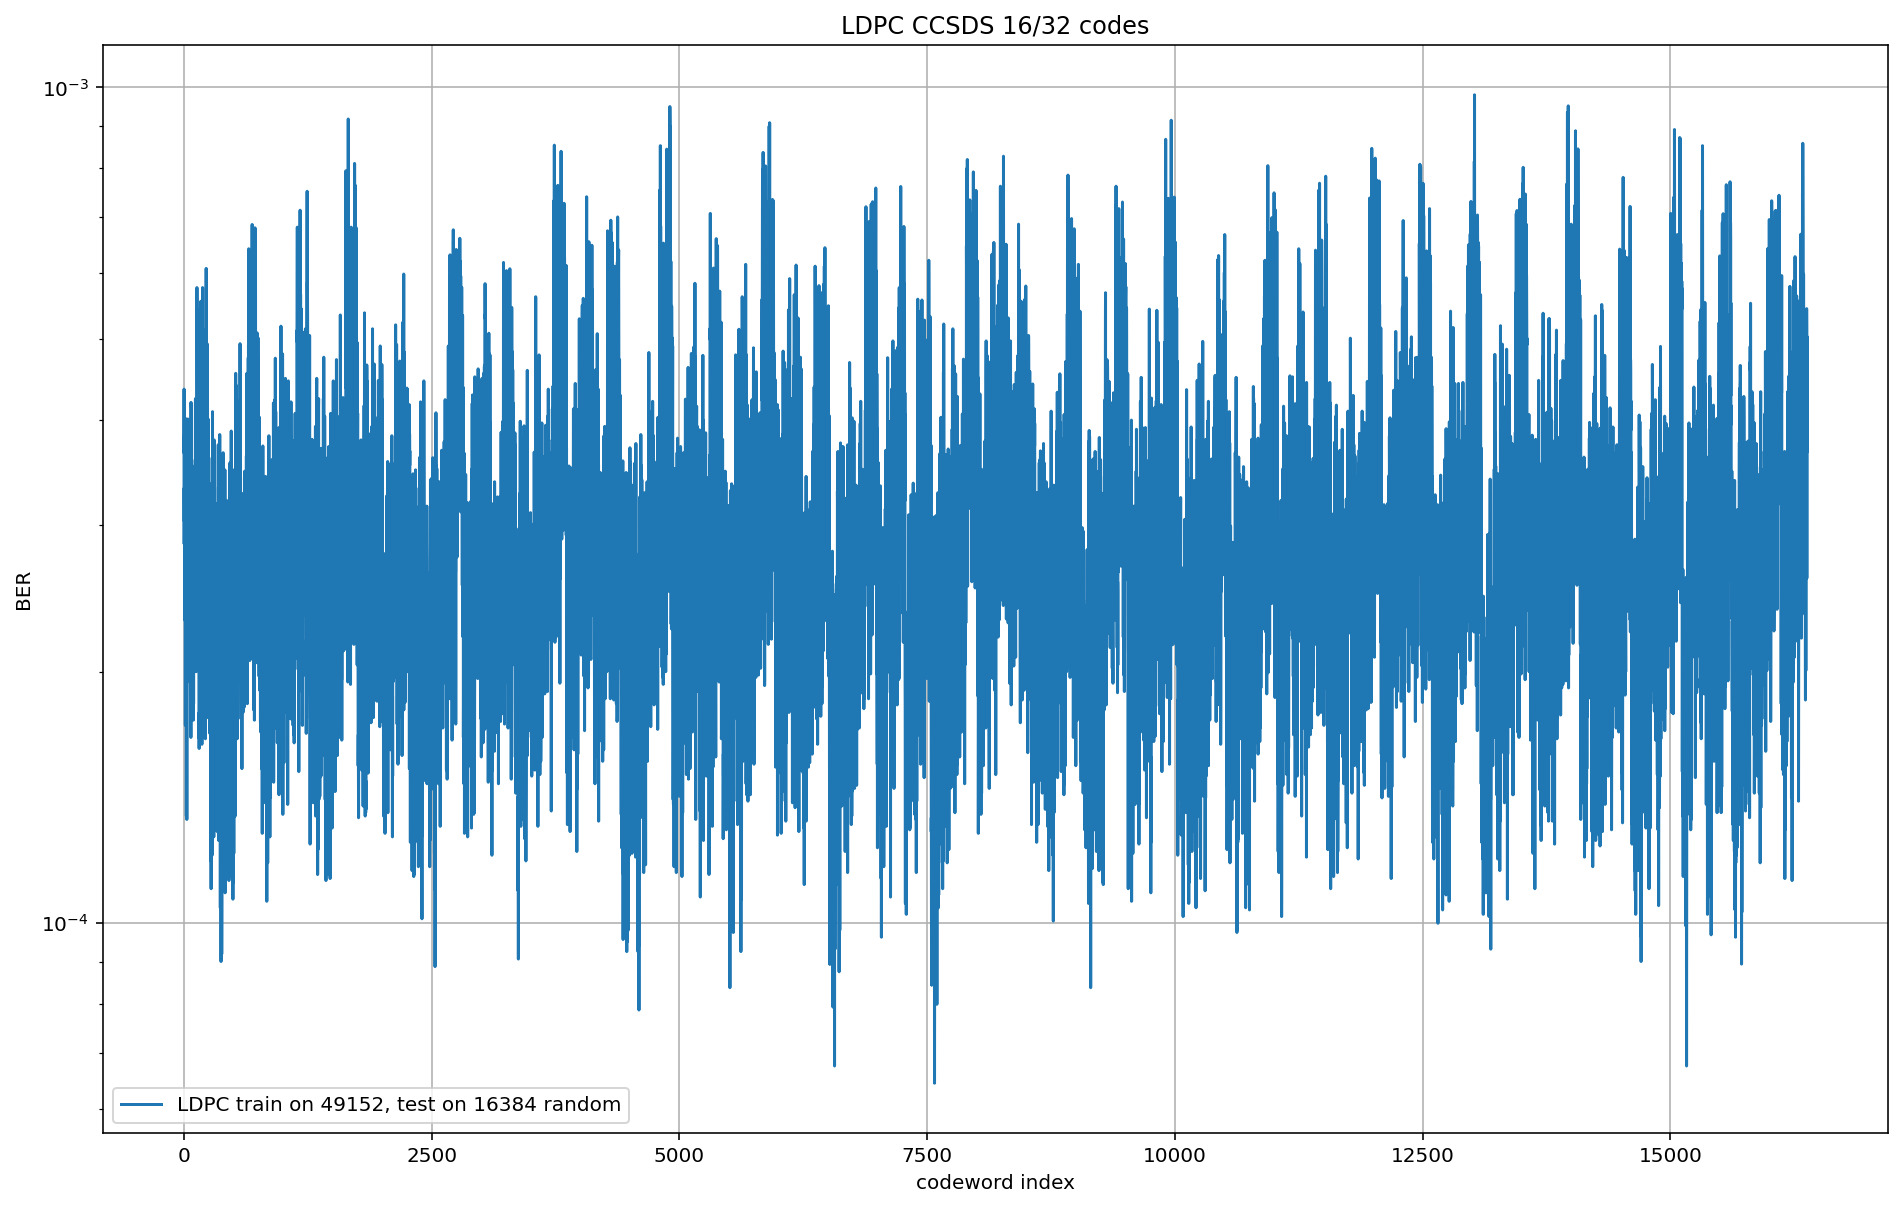

In [40]:
legend = []
plt.figure(figsize = (16, 10))
for experiment in [0]:
    plt.plot(errors[experiment,:,-1]/bits[experiment,:,-1])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

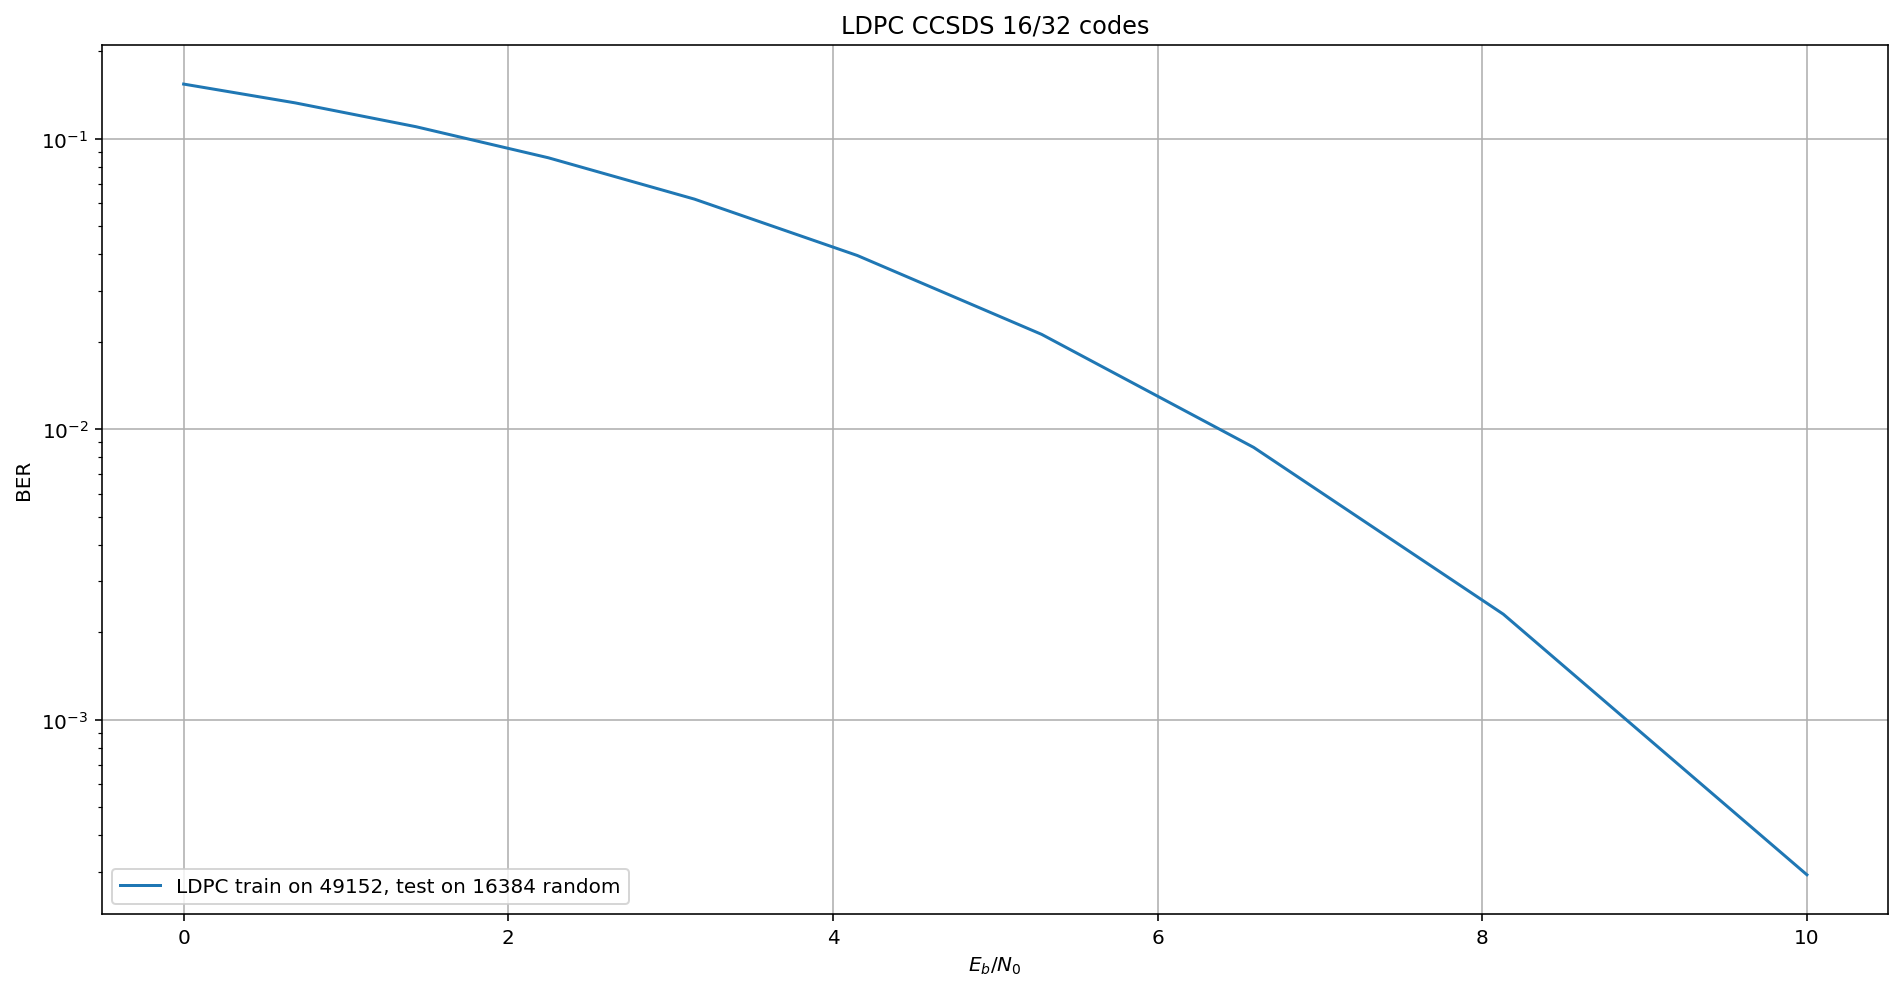

In [41]:
ber = np.sum(errors, axis=1) / np.sum(bits, axis=1)

legend = []

plt.figure(figsize = (16, 8))
for experiment in [0]:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

(array([4938., 4879., 4871., 4862., 4927., 4966., 4935., 4906., 4942.,
        4926.]),
 array([1.00000e+00, 6.55440e+03, 1.31078e+04, 1.96612e+04, 2.62146e+04,
        3.27680e+04, 3.93214e+04, 4.58748e+04, 5.24282e+04, 5.89816e+04,
        6.55350e+04]),
 <BarContainer object of 10 artists>)

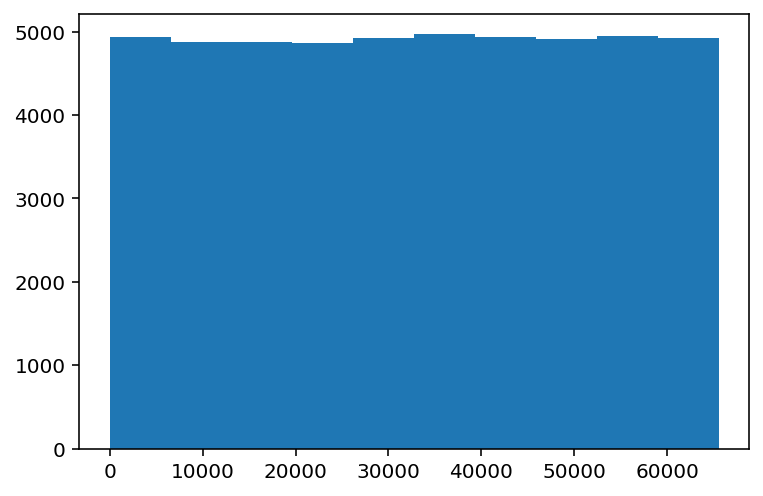

In [47]:
plt.hist(idx, bins=10)

## Load polar codes results

In [54]:
# number of errors in .npy format
bits_polar = np.load('codebook/iterative-picking/262144-train_1000000-test/bits_16-240_29-227_52-204_86-170_30-226.npy')

In [55]:
# number of errors in .npy format
errors_polar = np.load('codebook/iterative-picking/262144-train_1000000-test/errors_16-240_29-227_52-204_86-170_30-226.npy')

In [57]:
exp_descr_polar = []

# open file and read the content in a list
with open('codebook/iterative-picking/262144-train_1000000-test/exp_descr.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        exp = line[:-1]

        # add item to the list
        exp_descr_polar.append(exp)
exp_descr_polar

['iterative picking, 16 train / 240 test',
 'iterative picking, 29 train / 227 test',
 'iterative picking, 52 train / 204 test',
 'iterative picking, 86 train / 170 test',
 'iterative picking, 30 train / 226 test',
 'first 16 elements',
 'first 32 elements',
 'first 64 elements',
 'first 128 elements',
 'random 16 elements',
 'random 32 elements',
 'random 64 elements',
 'random 128 elements',
 'random 86 elements',
 'Train on basis (identity matrix)']

In [61]:
exp_descr_polar[12]

'random 128 elements'

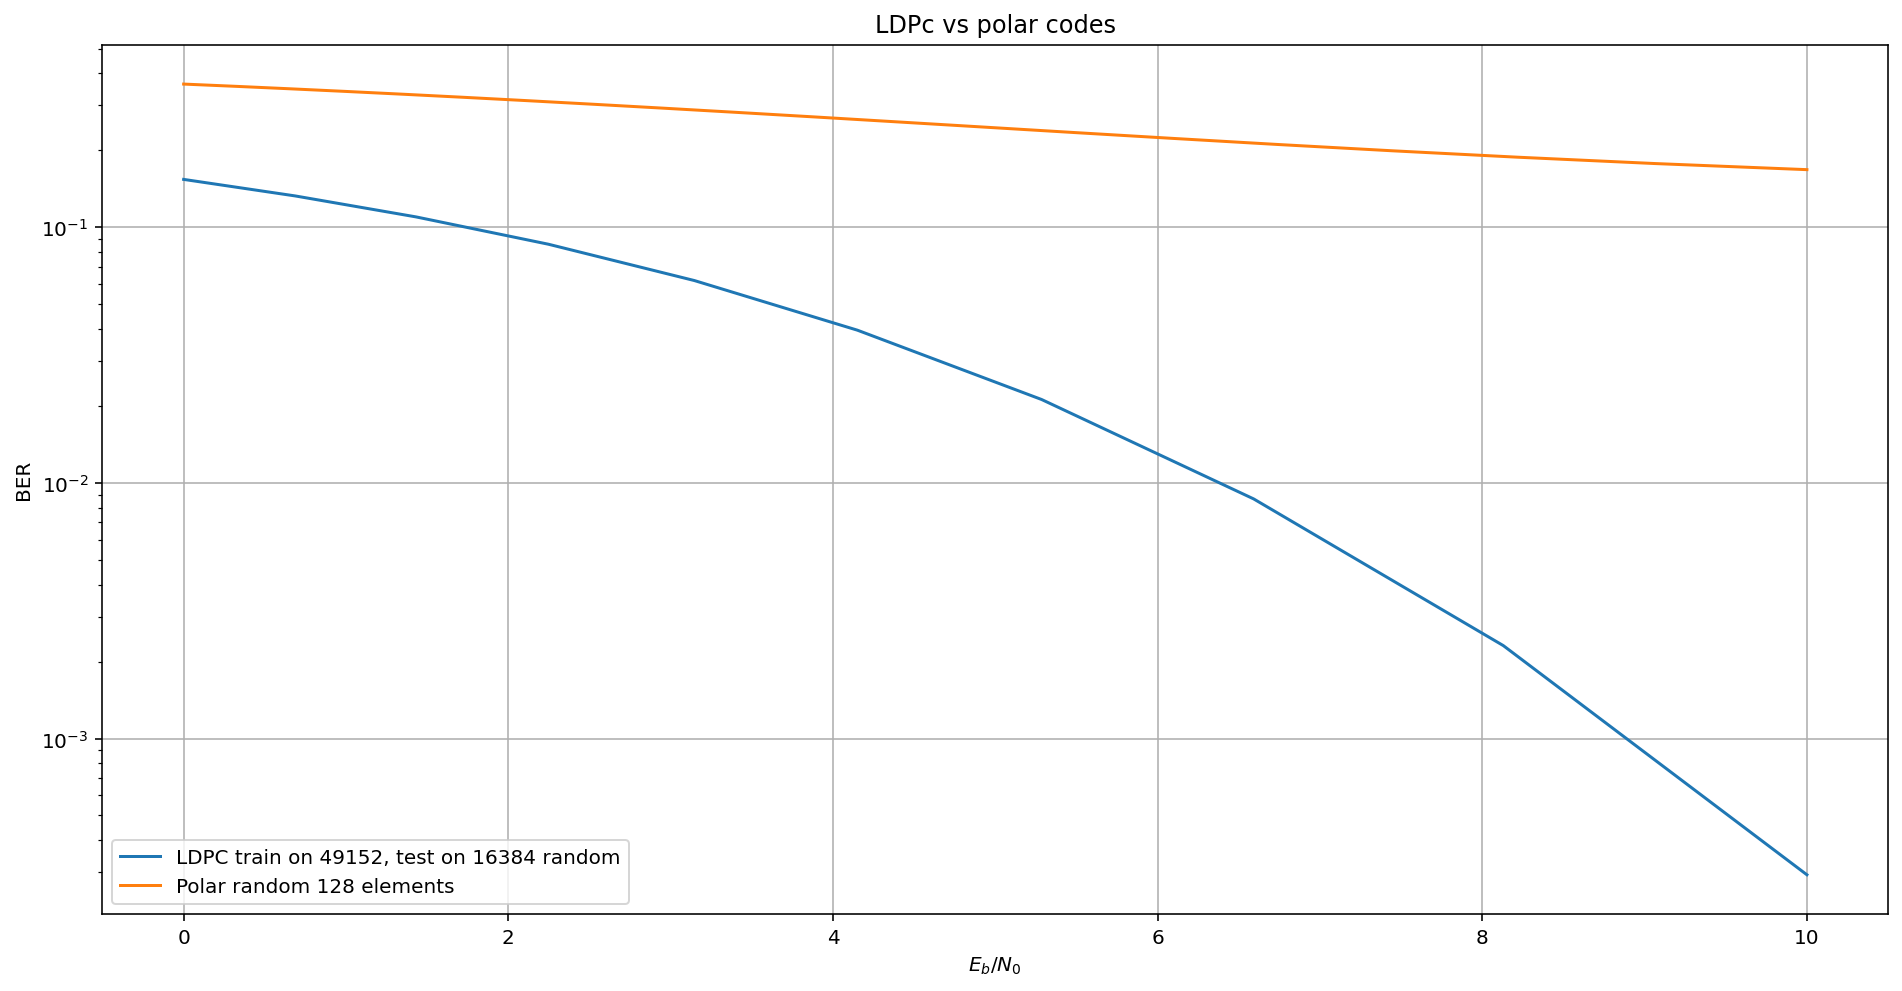

In [66]:
legend = []

# LDPC codes
ber = np.sum(errors, axis=1) / np.sum(bits, axis=1)
plt.figure(figsize = (16, 8))
for experiment in [0]:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
    legend.append(exp_descr[experiment])

    
# Polar codes
ber_polar = np.sum(errors_polar, axis=1) / np.sum(bits_polar, axis=1)
k_polar = 8
N_polar = 16
SNR_dB_start_Eb_polar = 0
SNR_dB_stop_Eb_polar = 10
SNR_points_polar = 20
SNR_dB_start_Es_polar = SNR_dB_start_Eb_polar + 10*np.log10(k_polar/N_polar)
SNR_dB_stop_Es_polar = SNR_dB_stop_Eb_polar + 10*np.log10(k_polar/N_polar)
sigma_start_polar = np.sqrt(1/(2*10**(SNR_dB_start_Es_polar/10)))
sigma_stop_polar = np.sqrt(1/(2*10**(SNR_dB_stop_Es_polar/10)))
sigmas_polar = np.linspace(sigma_start_polar, sigma_stop_polar, SNR_points_polar)

for experiment in [12]:
    plt.plot(10*np.log10(1/(2*sigmas_polar**2)) - 10*np.log10(k/N), ber_polar[experiment])
    legend.append('Polar ' + exp_descr_polar[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title('LDPc vs polar codes')
plt.show()

# Analyse predictions

In [72]:
predictions = np.zeros((inputs_test.shape[0], k), dtype = bool)
# print(f'CW #,  predicted        |  inputs')
for i in range(0, codewords_test.shape[0]):
    s_test = -2*codewords_test[i] + 1
    y_test = s_test + sigmas[-1]*np.random.standard_normal(s_test.shape)
    predictions[i] = np.round(decoder.predict(np.reshape(y_test, (1, N)), batch_size=1))
#     print(f'CW:{i+inputs_train.shape[0]} {predictions[i].astype(int)} | {inputs_test[i].astype(int)}')
    print(f'CW:{i+inputs_train.shape[0]}/{codewords.shape[0]}', end='\r')

In [76]:
test = np.array([], dtype=int)
for current_input in inputs_train:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+inputs_train.shape[0]))
print('indicies of predicted codewords which exist in train set:')
print(f'indicies: {np.sort(test)}, shape: {test.shape}')

indicies of predicted codewords which exist in train set:
indicies: [49510 49560 49802 49933 50090 50369 50695 51176 51771 53180 53223 53694
 53793 54628 54993 55914 55968 56034 56469 56470 57146 57218 57259 57378
 57608 57993 58119 58519 58554 58572 58683 59177 59423 59494 59777 59843
 60125 60666 61332 61558 61628 61723 62013 62337 62860 63084 63295 63443
 63642 63919 64100 64167 64191 64407 64438 64720 65139 65496], shape: (58,)


In [77]:
test = np.array([], dtype=int)
for current_input in inputs_test:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+inputs_train.shape[0]))
print('indicies of predicted codewords which ARE NOT INCLUDED into train set:')
print(f'indicies: {np.sort(test)}, shape: {test.shape}')

indicies of predicted codewords which ARE NOT INCLUDED into train set:
indicies: [49152 49153 49154 ... 65533 65534 65535], shape: (16326,)


In [84]:
test = np.array([], dtype=int)
for i in range(0, inputs_test.shape[0]):
    if ((predictions[i] == inputs_test[i]).all(axis=0)):
        test = np.append(test, (i+inputs_train.shape[0]))
#         print(i+inputs_train.shape[0])
print(f'Indicies of correctly predicted codewords, which WERE NOT INCLUDED into train set: {test.shape[0]}')

Indicies of correctly predicted codewords, which WERE NOT INCLUDED into train set: 16310
